In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
#from utils.utils import L1_data, SWMF
import time
import datetime as dt
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import scipy.stats

In [2]:
def ids_from_df(df):
    time  = dt.datetime(int(df['YEAR']), 1, 1) + dt.timedelta(df['DOY'] - 1)
    month = time.month
    year  = time.year
    day   = time.day
    hour = int(df['Hour']) 
    id_ = str(year).zfill(2) + str(month).zfill(2) + str(day).zfill(2) + '_' + str(hour).zfill(2)
    return id_

In [3]:
shift = 1
oversample = True
format_ = []
with open('./omni_hourly_format.txt', 'r') as file:
    for i,line in enumerate(file):
        if i > 3:
            b = line.split('  ')[0].split()[1:]
            title = ' '.join(b)
            format_.append(title)
            #print(i,title)
labels = pd.read_csv('./omni_hourly.txt', sep='\s+', names = format_ )

In [4]:
labels['SW speed moving avg'] =  labels['SW Plasma Speed, km/s'].rolling(window=24).mean()
labels['SW density moving avg'] =  labels['SW Proton Density, N/cm^3'].rolling(window=24).mean()
labels = labels.iloc[24:]

In [5]:
labels['ids']   = labels.apply(ids_from_df, axis=1)

In [6]:
dates = labels['ids'].to_list()

In [7]:
OMNI_dict = labels.set_index('ids').T.to_dict()

In [8]:
dates[1000]

'20080212_16'

In [9]:
dates[1000 - 24]

'20080211_16'

In [10]:
def calc_persistence(OMNI_dict, qty, shift):
    true = []
    shifted = []
    
    for i in range(shift + 24, len(dates)):        
        true.append(OMNI_dict[dates[i] ][qty])
        shifted.append(OMNI_dict[dates[i - shift*24] ][qty])
            
    return scipy.stats.pearsonr(true, shifted)[0]

In [11]:
for col in labels.columns:
    print(col)

YEAR
DOY
Hour
Bartels rotation number
ID for IMF spacecraft
ID for SW Plasma spacecraft
# of points in IMF averages
# of points in Plasma averag. I4
Scalar B, nT
Vector B Magnitude,nT
Lat. Angle of B (GSE)
Long. Angle of B (GSE)
BX, nT (GSE, GSM)
BY, nT (GSE)
BZ, nT (GSE)
BY, nT (GSM)
BZ, nT (GSM)
RMS_magnitude, nT
RMS_field_vector, nT
RMS_BX_GSE, nT
RMS_BY_GSE, nT
SW Plasma Temperature, K
SW Proton Density, N/cm^3
SW Plasma Speed, km/s
SW Plasma flow long. angle
SW Plasma flow lat. angle
Alpha/Prot. ratio
sigma-T,K
sigma-n, N/cm^3)
sigma-V, km/s
sigma-phi V, degrees
sigma-theta V, degrees
sigma-ratio
Flow pressure
E elecrtric field
Plasma Beta
Alfen mach number
Magnetosonic Much num.
Quasy-Invariant
Kp index
R (Sunspot No.)
Dst-index, nT
ap_index, nT
f10.7_index
AE-index, nT
AL-index, nT
AU-index, nT
pc-index
Lyman_alpha
Proton flux (>1 Mev)
Proton flux (>2 Mev)
Proton flux (>4 Mev)
Proton flux (>10 Mev)
Proton flux (>30 Mev)
Proton flux (>60 Mev)
Flux FLAG
SW speed moving avg
SW dens

In [14]:
calc_persistence(OMNI_dict, 'SW speed moving avg', 1)

0.29780785252055775

In [12]:
calc_persistence(OMNI_dict, 'SW density moving avg', 1)

0.36890474375276544

In [14]:
shifts = [1, 2, 3, 4, 5, 6, 7]

for shift in shifts:
    print("Shift: ", shift)
    var = 'SW speed moving avg'
    print(str(round(calc_persistence(OMNI_dict, var, shift), 3)), " , " +  var)
    var = 'SW density moving avg'
    print(str(round(calc_persistence(OMNI_dict, var, shift), 3)), " , " +  var)
       
    print('\n')

Shift:  1
0.298  , SW speed moving avg
0.369  , SW density moving avg


Shift:  2
0.046  , SW speed moving avg
0.22  , SW density moving avg


Shift:  3
0.024  , SW speed moving avg
0.2  , SW density moving avg


Shift:  4
0.084  , SW speed moving avg
0.147  , SW density moving avg


Shift:  5
0.095  , SW speed moving avg
0.157  , SW density moving avg


Shift:  6
0.044  , SW speed moving avg
0.104  , SW density moving avg


Shift:  7
0.031  , SW speed moving avg
0.073  , SW density moving avg




In [85]:
shifts = [1, 2, 3, 4, 5, 6, 7]

for shift in shifts:
    print("Shift: ", shift)
    print(str(round(calc_persistence(OMNI_dict, 'SW Plasma Speed, km/s', shift), 3)).zfill(5), " , SW Plasma Speed, km/s")
    print(str(round(calc_persistence(OMNI_dict, 'Scalar B, nT', shift), 3)).zfill(5), " , Scalar B, nT")    
    print(str(round(calc_persistence(OMNI_dict, 'BZ, nT (GSM)', shift), 3)).zfill(5), " , BZ, nT (GSM)")    
    print(str(round(calc_persistence(OMNI_dict, 'SW Proton Density, N/cm^3', shift), 3)).zfill(5), " , SW Proton Density, N/cm^3")    
    print(str(round(calc_persistence(OMNI_dict, 'SW Plasma Temperature, K', shift), 3)).zfill(5), " , SW Plasma Temperature, K")    
    print('\n')

Shift:  1
0.096  , SW Plasma Speed, km/s
0.038  , Scalar B, nT
0.034  , BZ, nT (GSM)
0.134  , SW Proton Density, N/cm^3
0.039  , SW Plasma Temperature, K


Shift:  2
0.016  , SW Plasma Speed, km/s
-0.001  , Scalar B, nT
-0.002  , BZ, nT (GSM)
0.114  , SW Proton Density, N/cm^3
0.034  , SW Plasma Temperature, K


Shift:  3
0.002  , SW Plasma Speed, km/s
-0.002  , Scalar B, nT
-0.002  , BZ, nT (GSM)
0.119  , SW Proton Density, N/cm^3
0.006  , SW Plasma Temperature, K


Shift:  4
0.058  , SW Plasma Speed, km/s
-0.002  , Scalar B, nT
-0.001  , BZ, nT (GSM)
0.072  , SW Proton Density, N/cm^3
0.026  , SW Plasma Temperature, K


Shift:  5
0.071  , SW Plasma Speed, km/s
0.066  , Scalar B, nT
0.059  , BZ, nT (GSM)
0.096  , SW Proton Density, N/cm^3
0.038  , SW Plasma Temperature, K


Shift:  6
0.004  , SW Plasma Speed, km/s
0.015  , Scalar B, nT
0.013  , BZ, nT (GSM)
0.057  , SW Proton Density, N/cm^3
-0.001  , SW Plasma Temperature, K


Shift:  7
0.012  , SW Plasma Speed, km/s
0.013  , Scalar 

In [72]:
a = np.arange(40000,41000,24)

(0.0, 800.0)

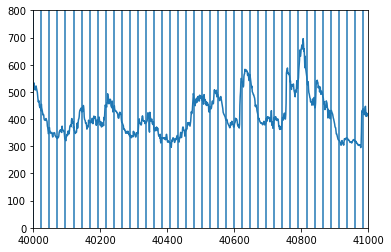

In [75]:
plt.plot( labels['SW Plasma Speed, km/s']  )
for i in a:
    plt.axvline(i)
plt.xlim(40000,41000)
plt.ylim(0,800)